# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('house_price_train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data.shape

(1460, 81)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

#### Удаление лишних признаков

In [6]:
data.drop('Id', axis=1, inplace=True)

In [7]:
data['Utilities'].value_counts() # можно удалить, всего 1 значение отличается

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [8]:
data.drop('Utilities', axis=1, inplace=True)

#### Заполнение пропусков признаков с непрерывными значениями средними значениями по столбцу

In [9]:
data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)
data['MasVnrArea'].fillna(data['MasVnrArea'].mean(), inplace=True)
data['GarageYrBlt'].fillna(data['GarageYrBlt'].mean(), inplace=True)

#### Преобразование категориальных признаков

In [10]:
cat_feat = list(data.dtypes[data.dtypes == object].index)
data[cat_feat] = data[cat_feat].fillna('nan')

In [11]:
dummy_data = pd.get_dummies(data[cat_feat])

In [12]:
data = pd.concat([data.drop(cat_feat, axis=1), dummy_data], axis=1)

In [13]:
data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=303)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 303 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(3), int64(34), uint8(266)
memory usage: 801.4 KB


#### Нормализация

In [15]:
scaled_features = StandardScaler().fit_transform(data.values)
scaled_data = pd.DataFrame(scaled_features, index=data.index, columns=data.columns)

In [16]:
scaled_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.511418,0.575425,-0.288653,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574410,1.171992,-0.288653,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
2,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.323060,0.092907,-0.288653,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
3,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,...,-0.058621,-0.301962,-0.045376,0.390293,3.668167,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995
4,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.364570,0.463568,-0.288653,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


## Случайный лес

Разделение выборки на трейн и тест

In [33]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data.drop('SalePrice', axis=1), 
                                                    scaled_data['SalePrice'], 
                                                    test_size=0.3,
                                                   random_state=17)

In [34]:
rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Важность признаков

In [35]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head()

,importance
OverallQual,0.673343
GrLivArea,0.114451
BsmtFinSF1,0.040788
TotalBsmtSF,0.038988
FullBath,0.033921


#### Оценка качества модели

In [36]:
scores_train = cross_val_score(rf, X_train, y_train, cv=10)

In [37]:
np.mean(scores_train)

0.7683708414919339

In [38]:
scores_test = cross_val_score(rf, X_test, y_test, cv=10)

In [39]:
np.mean(scores_test)

0.7499188814281804

## Стекинг

In [40]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [41]:
rg = Ridge(random_state=17)
rf = RandomForestRegressor(random_state=17)
svr = SVR()
knn = KNeighborsRegressor()

In [42]:
stack_cv = KFold(n_splits=10, random_state=20)

meta_train = []
meta_test = []
col_names = []

print('Ridge features...')
meta_tr, meta_te = get_meta_features(rg, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rg_pred')

print('RandomForest features...')
meta_tr, meta_te = get_meta_features(rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('SupportVectorRegression features...')
meta_tr, meta_te = get_meta_features(svr, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('svr_pred')

print('KNeighborsRegressor features...')
meta_tr, meta_te = get_meta_features(knn, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('knn_pred')

Ridge features...
RandomForest features...
SupportVectorRegression features...
KNeighborsRegressor features...


In [43]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

#### Стекинг мета-признаков

In [44]:
rg_meta = Ridge(random_state=17)
rg_meta.fit(X_meta_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

#### Оценка стекинга

In [45]:
scores_meta_test = cross_val_score(rg_meta, X_meta_test, y_test, cv=10)

In [46]:
np.mean(scores_meta_test)

0.9019062827880232

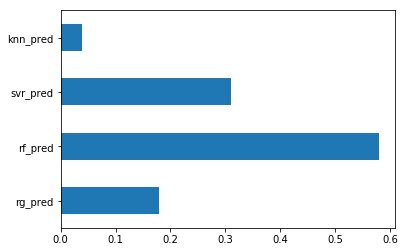

In [47]:
pd.Series(rg_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh');

####  Сравнение стекинга с отдельными моделями

In [48]:
rg = Ridge(random_state=17).fit(X_train, y_train)

In [50]:
scores_rg_test = cross_val_score(rg, X_test, y_test, cv=10)
np.mean(scores_rg_test)

0.7823557218344142

RandomForest

In [51]:
rf = RandomForestRegressor(random_state=17).fit(X_train, y_train)

In [52]:
scores_rf_test = cross_val_score(rf, X_test, y_test, cv=10)
np.mean(scores_rf_test)

0.8453009487335225

SVR

In [53]:
svr = SVR().fit(X_train, y_train)

In [54]:
scores_svr_test = cross_val_score(svr, X_test, y_test, cv=10)
np.mean(scores_svr_test)

0.7955306736464347

KNN

In [55]:
knn = KNeighborsRegressor().fit(X_train, y_train)

In [56]:
scores_knn_test = cross_val_score(knn, X_test, y_test, cv=10)
np.mean(scores_knn_test)

0.7226656848843779

Как видно, оценка стекинга превышает оценки отдельно взятых моделей.